In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import sys
from pathlib import Path

sys.path.insert(0, Path('').resolve().parent.parent.as_posix())
from utils import dl_modules
from utils.dataset import SinSequenceDataset

# 训练

train loss 0.011, train acc 0.000
8487.3 examples/sec on cuda:0


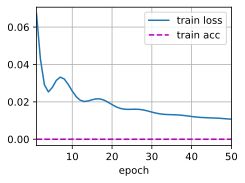

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


lr, num_epochs, batch_size, n_train = 0.01, 50, 16, 600
dataset = SinSequenceDataset(num_examples=1000, tau=4)
train_dataloader = dataset.get_dataloader(batch_size, n_train)
net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
net.apply(init_weights)
loss = nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

dl_modules.train(net, train_dataloader, None, optimizer, loss, num_epochs)

# 预测

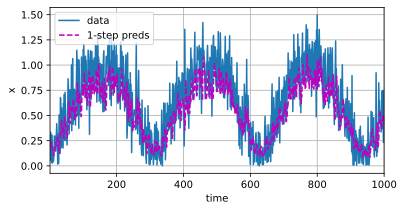

In [8]:
time, x, features = dataset.time, dataset.x, dataset.features
net.cpu()
onestep_preds = net(features)
tau = 4
dl_modules.plot(
    [time, time[tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy()],
    "time",
    "x",
    legend=["data", "1-step preds"],
    xlim=[1, 1000],
    figsize=(6, 3),
)

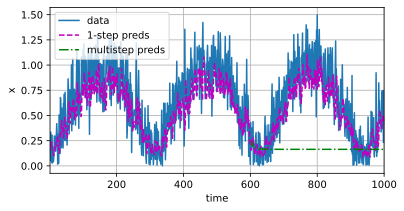

In [10]:
T = 1000
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau : i].reshape((1, -1)))

dl_modules.plot(
    [time, time[tau:], time[n_train + tau :]],
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau :].detach().numpy()],
    "time",
    "x",
    legend=["data", "1-step preds", "multistep preds"],
    xlim=[1, 1000],
    figsize=(6, 3),
)

## k步预测

In [11]:
max_steps = 64

In [12]:
T = 1000
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i : i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau : i]).reshape(-1)

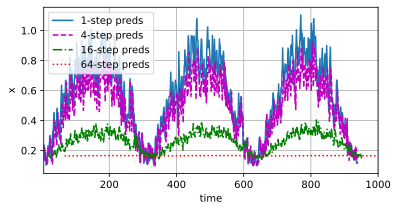

In [13]:
steps = (1, 4, 16, 64)
dl_modules.plot(
    [time[tau + i - 1 : T - max_steps + i] for i in steps],
    [features[:, tau + i - 1].detach().numpy() for i in steps],
    "time",
    "x",
    legend=[f"{i}-step preds" for i in steps],
    xlim=[5, 1000],
    figsize=(6, 3),
)